# This notebook compares the expression of miRNA families' target genes expression with boxplots visualization
- between top 20% and bottoom 20% population ranked  on all_target score 

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn 
import sys
import os

In [2]:
import calculation_function as calc

In [3]:
sc.set_figure_params(figsize=[5,5])

## Functions

In [12]:
def long_format_score_df(rank_df, miRNA_fam_names, adat_header, fam_range):
    """This function convert a wide format dataframe to a long format one 
    param rank_df: the wide DF that has the gene scores and ranking based on all_target gene scores
    param miRNA_fam_names: the miRNA families to keep 
    adat_header: the overall dataset header anndata obj
    fam_range: used when you want to analyse a subset of families 
    
    return result_df: the long format df with 3 columns: ["score", "rank", "miRNA_famly"]
    """
    result_df = pd.DataFrame()
    init_num = 0
    for i in range(fam_range[0], fam_range[1]):
        fam = miRNA_fam_names[i]
        score_df = adat_header.obs[fam][rank_df.index]
        #score_df.columns = ["score"]
        #name_series = pd.Series([fam[0:min(len(fam), 12)] for num in range(rank_df.shape[0])], index = rank_df.index)
        name_series = pd.Series([fam for num in range(rank_df.shape[0])], index = rank_df.index)
        score_df = pd.concat([score_df, rank_df["rank"], name_series], axis = 1)
        score_df.columns = ["score", "rank", "miRNA_famly"]
        if(init_num ==0):
            result_df = score_df
        else:
            result_df = pd.concat([result_df, score_df], axis = 0)
        init_num +=1 
    
    print(result_df.shape)
    return result_df

In [13]:
def plot_score_df(rank_df, miRNA_family_names, adat_header, fam_range, 
                  plot_title, save= None, 
                  ylim = [-1, 3], fig_size = (16,8), ):
    """This function make the box plot"""

    dat_df = long_format_score_df(rank_df, miRNA_family_names, adat_header, fam_range)
    sn.set(rc = {'figure.figsize':fig_size, 'axes.facecolor': 'white',
 'axes.edgecolor': 'black'})
    ax = sn.boxplot(x = "miRNA_famly", y = "score", hue = "rank", data = dat_df, fliersize = 0.5, palette="Set3")
    x = ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    ax.set_title(plot_title)
    ax.grid(False)
    ax.set_facecolor('white')
    if(ylim):
        ax.set_ylim(ylim[0], ylim[1])
    if(save):
        plt.savefig(save)
    return dat_df

In [14]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest

def plot_stat_annotation(plotting_parameters, dat_df, pairs, ax = None):
    # Create new plot
    if(not ax):
        _,ax = plt.subplots()

    # Plot with seaborn
    sn.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs=pairs, **plotting_parameters)
    #annotator.new_plot()
    annotator.configure(test='Mann-Whitney', verbose=True).apply_and_annotate()

    # Label and show
    return ax

## Load data

In [4]:
data_path = "/home/lucy/miRNA_subset_h5ad/"

In [7]:
selected_miR_fam = pd.read_csv("./TOP_10_miR_family_in_CRC.csv")
selected_miR_fam.head()

,miR.family,baseMean,peak.number
0,let-7-5p/miR-98-5p,16465.710160,779
1,miR-15-5p/16-5p/195-5p/322-5p/497-5p,5286.547861,473
2,miR-29-3p,1411.369229,463
3,miR-200-3p/429-3p,35895.615870,431
4,miR-17-5p/20-5p/93-5p/106-5p,18199.014110,425


In [8]:
selected_miR_fam = selected_miR_fam["miR.family"]

In [11]:
header = sc.read(os.path.join(data_path, "disc_header.h5ad"))

In [5]:
asc = sc.read(os.path.join(data_path, "asc.h5ad"))

In [6]:
asc

AnnData object with n_obs × n_vars = 7594 × 35272
    obs: 'HTAN Parent Data File ID', 'HTAN Specimen ID', 'Cell_Type', 'Polyp_Type', 'Sample_Classification', 'Patient', 'KRAS_mutation', 'all_targets', 'miR-10-5p', 'miR-135ab-5p', 'miR-218-5p', 'miR-190-5p', 'miR-193-3p', 'miR-33-5p', 'miR-182-5p', 'miR-362-5p', 'miR-23-3p', 'miR-18-5p', 'miR-18-3p/7069-3p', 'miR-194-2-3p/6926-5p/7055-5p', 'miR-130-3p/301-3p', 'miR-103-3p/107-3p', 'miR-205-5p', 'miR-183-3p', 'miR-7-5p', 'miR-423-3p', 'miR-501-5p', 'miR-185-5p', 'miR-423-5p', 'miR-26-5p', 'miR-147-3p', 'miR-484', 'miR-378-3p', 'miR-22-3p', 'miR-652-3p', 'miR-374b-5p', 'miR-210-3p', 'miR-194-5p', 'miR-192-5p/215-5p', 'miR-196-5p', 'miR-324-3p', 'miR-27-3p', 'miR-141-3p', 'miR-1198-5p', 'miR-19-3p', 'miR-183-5p', 'let-7-5p/miR-98-5p', 'miR-200-3p/429-3p', 'miR-3081-3p', 'miR-125ab-5p/351-5p', 'miR-28-3p', 'miR-181-5p', 'miR-151-3p', 'miR-24-3p', 'miR-96-5p', 'miR-186-5p', 'miR-425-5p/489-3p', 'miR-17-5p/20-5p/93-5p/106-5p', 'miR-21ac-5p',

## ASC Analysis

In [15]:
asc_df = pd.DataFrame(asc.obs["all_targets"])

In [16]:
asc_df["rank"] = ["middle" for i in range(asc.n_obs)]

In [18]:
asc_df = asc_df.sort_values(by = "all_targets", ascending= False)

In [19]:
asc_df["rank"][0:int(0.2*asc.n_obs)] = ["top20%" for i in range(int(0.2*asc.n_obs))]

/tmp/ipykernel_227829/1118371960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asc_df["rank"][0:int(0.2*asc.n_obs)] = ["top20%" for i in range(int(0.2*asc.n_obs))]
/home/lucy/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [20]:
asc_df["rank"][int(0.8*asc.n_obs):asc.n_obs] = "bottom20%" 

/tmp/ipykernel_227829/2961736271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asc_df["rank"][int(0.8*asc.n_obs):asc.n_obs] = "bottom20%"


In [21]:
asc_df2 = asc_df[asc_df["rank"] == "top20%"]
asc_df2 = pd.concat([asc_df2, asc_df[asc_df["rank"] == "bottom20%"]], axis = 0)

In [22]:
asc_rank = pd.DataFrame( asc_df2["rank"] )

In [23]:
asc_rank.columns = ["rank"]
asc_rank.head()

,rank
GACATTTGTTGTTTACGT-90,top20%
CTTTAATCATACCCAG-81,top20%
ACAACGTGGTCGGTTCG-90,top20%
ACCCTTGGTTTCCGCTC-90,top20%
TAGCCTCGCTTCAGGT-81,top20%


(30370, 3)


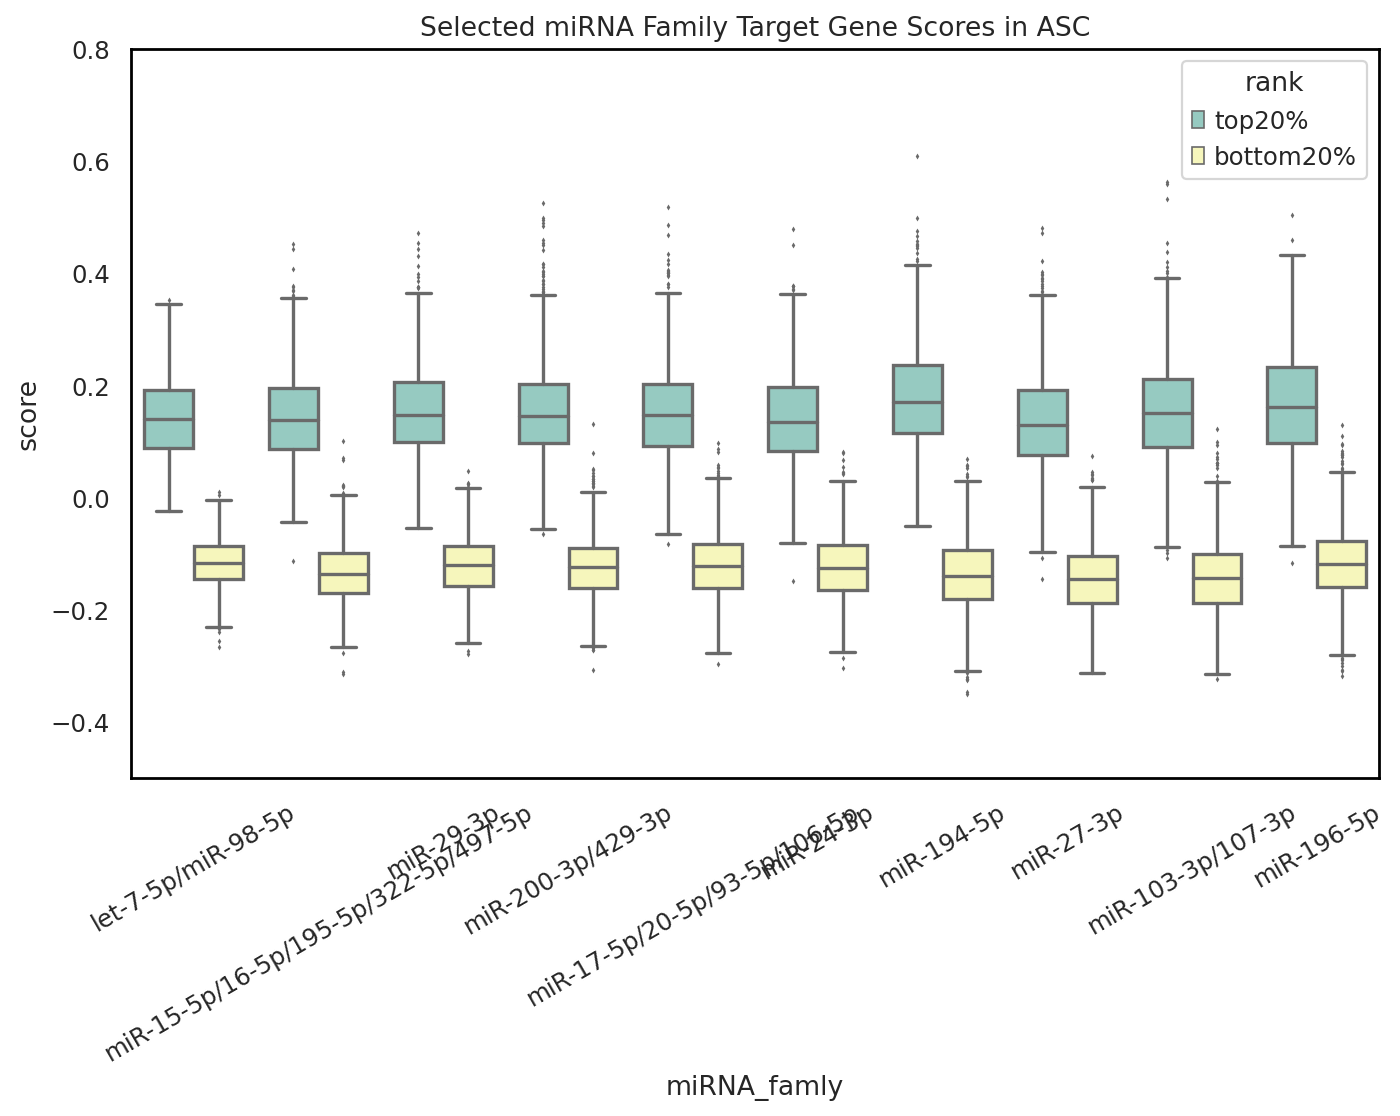

In [24]:
asc_selected_fam_df = plot_score_df(asc_rank, selected_miR_fam, header, [0,10], 
                            "Selected miRNA Family Target Gene Scores in ASC",
                                   fig_size=(10,6), ylim=[-0.5,0.8], )

### with statistical notation

In [25]:
rank_choice = ['top20%', 'bottom20%']

pairs = [ [(s, r)  for r in rank_choice] for s in selected_miR_fam ]

In [26]:
pairs[0:5]

[[('let-7-5p/miR-98-5p', 'top20%'), ('let-7-5p/miR-98-5p', 'bottom20%')],
 [('miR-15-5p/16-5p/195-5p/322-5p/497-5p', 'top20%'),
  ('miR-15-5p/16-5p/195-5p/322-5p/497-5p', 'bottom20%')],
 [('miR-29-3p', 'top20%'), ('miR-29-3p', 'bottom20%')],
 [('miR-200-3p/429-3p', 'top20%'), ('miR-200-3p/429-3p', 'bottom20%')],
 [('miR-17-5p/20-5p/93-5p/106-5p', 'top20%'),
  ('miR-17-5p/20-5p/93-5p/106-5p', 'bottom20%')]]

In [27]:
# format with statistical tests
dat_df = long_format_score_df(asc_rank, selected_miR_fam, header, [0,10])

plotting_parameters = {
    "x": "miRNA_famly", 
    "y": "score", 
    "hue" : "rank", 
    "data" : dat_df, 
    "fliersize" : 0.5, 
    "palette": "Set3"
}



(30370, 3)


In [28]:
dat_df["miRNA_famly"][0]

'let-7-5p/miR-98-5p'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

miR-196-5p_top20% vs. miR-196-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.293e+06
miR-103-3p/107-3p_top20% vs. miR-103-3p/107-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.297e+06
miR-15-5p/16-5p/195-5p/322-5p/497-5p_top20% vs. miR-15-5p/16-5p/195-5p/322-5p/497-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.303e+06
let-7-5p/miR-98-5p_top20% vs. let-7-5p/miR-98-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.306e+06
miR-29-3p_top20% vs. miR-29-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.304e+06
miR-200-3p/429-3p_top20% vs. miR-200-3p/429-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.303e+06
miR-17-5p/20-5p/93-5p/106-5p_top20%

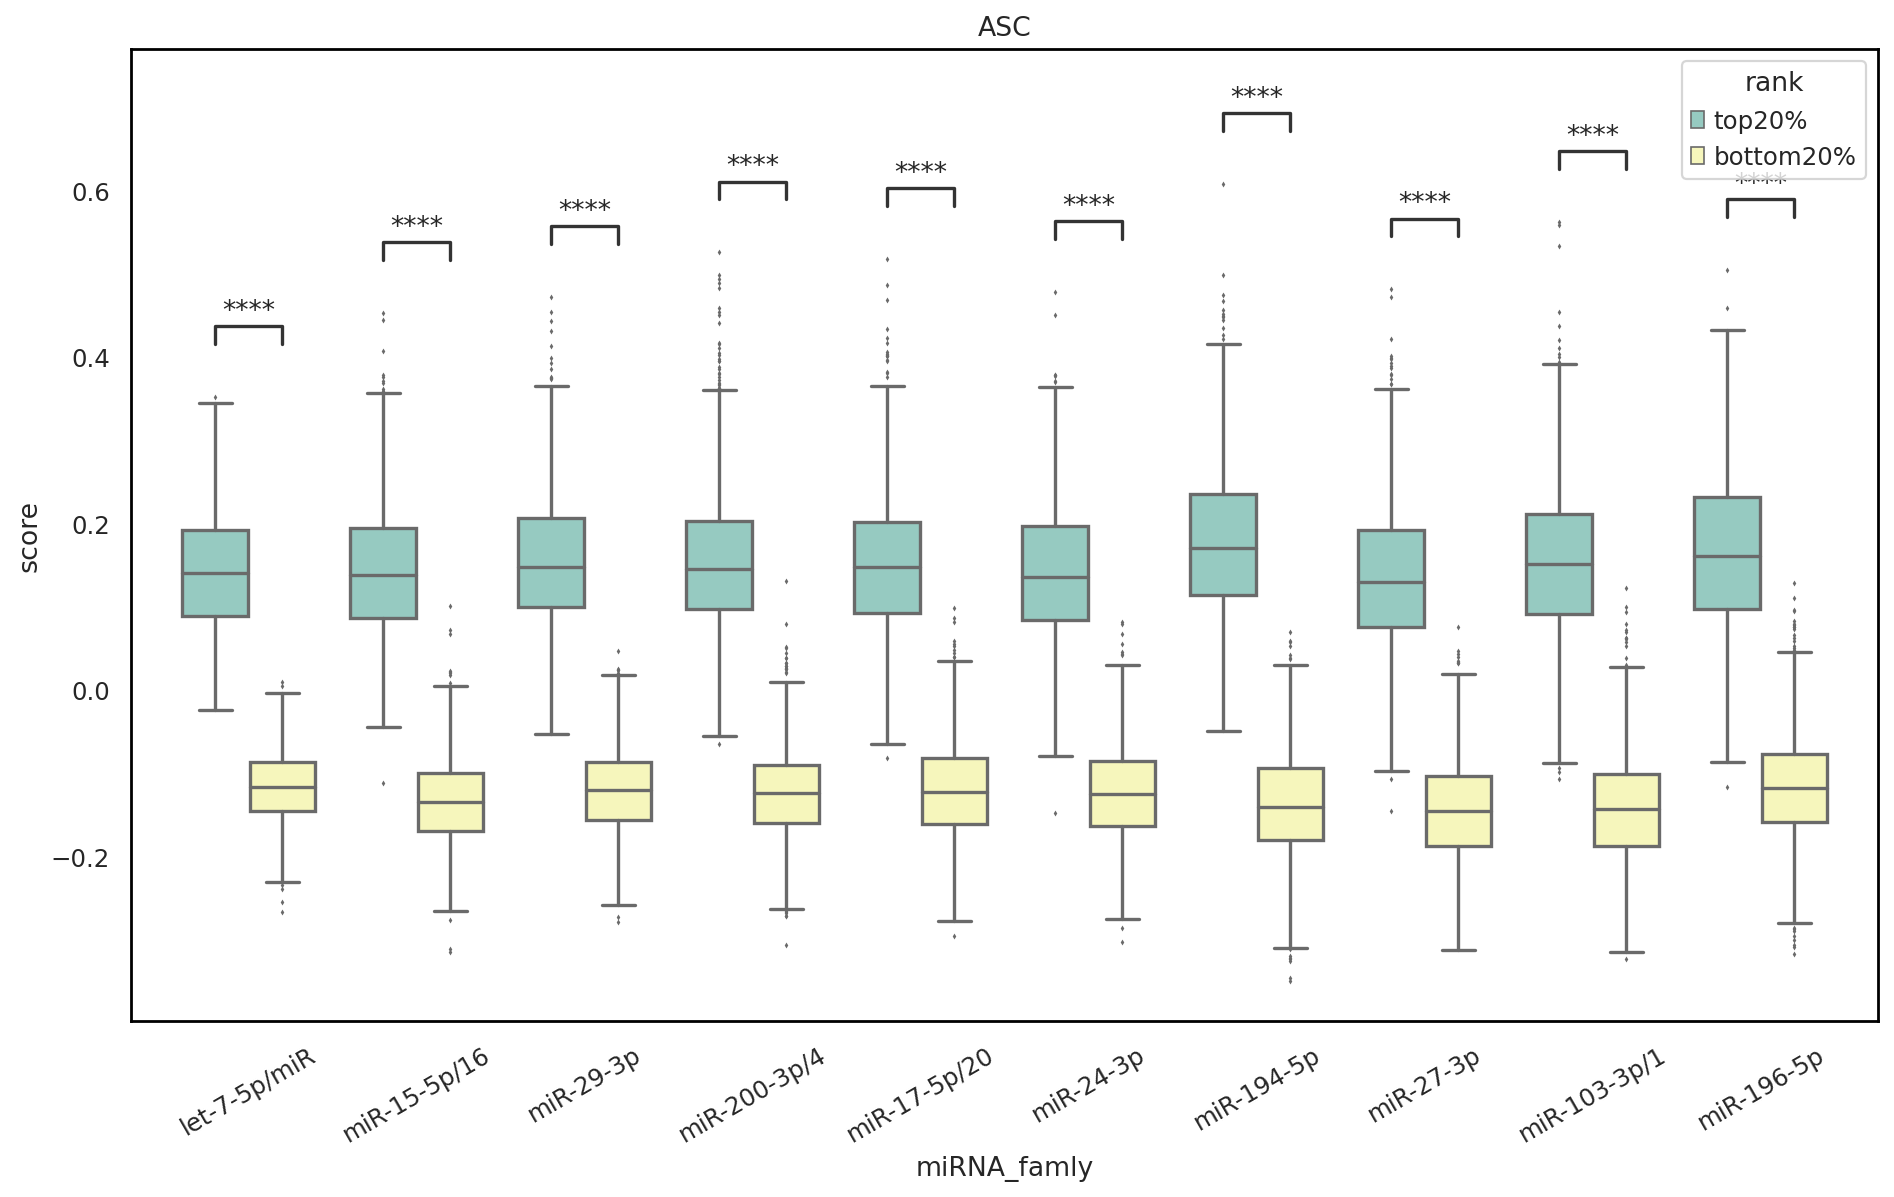

In [30]:
_,ax = plt.subplots()


plot_stat_annotation(plotting_parameters, dat_df, pairs, ax = ax)
short_selected_name = [fam[0:min(len(fam), 12)] for fam in selected_miR_fam] #cut off miRNA fam names that are too long 
ax.set_xticklabels(short_selected_name,rotation = 30)
ax.set_title("ASC")
ax.grid(False)
sn.set(rc = {'figure.figsize':(14,8), 'axes.edgecolor': 'black', 'axes.facecolor': 'white'})

#plt.savefig("./figures/box_ASC.pdf", bbox_inch = 'tight')

## SSC Analysis

In [32]:
ssc = sc.read(os.path.join(data_path, "ssc.h5ad") )

In [33]:
ssc.X.sum(axis = 1)

array([10313.,  5099.,  5595., ..., 16266.,  8101.,  7799.], dtype=float32)

In [35]:
ssc_rank_df = pd.DataFrame(ssc.obs["all_targets"])
ssc_rank_df["rank"] = ["middle" for i in range(ssc.n_obs)]

In [36]:
ssc_rank_df

,all_targets,rank
GAGATCTCGGTGTACACG-0,-0.004842,middle
TGAAAACAGGGACGGTAGC-0,-0.123149,middle
GAAGGAAGACGATTAGAC-0,-0.037469,middle
GCTCTAGTTAGTGGAC-0,-0.011602,middle
GATCTCAACCGGACTTCC-0,0.065556,middle
...,...,...
GACCCGAATGTACTTGTG-93,0.007254,middle
GAACCACGCTGTGGATGG-93,-0.189656,middle
GTTACGATCTACGAGC-93,-0.016212,middle
GATCGGTTTACTTACGGG-93,-0.128083,middle


In [37]:
ssc_rank_df = ssc_rank_df.sort_values(by = "all_targets", ascending= False)
ssc_rank_df["rank"][int(0.8*ssc.n_obs):ssc.n_obs] = "bottom20%" 
ssc_rank_df["rank"][0:int(0.2*ssc.n_obs ) ] = "top20%" 

/tmp/ipykernel_227829/1672530500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssc_rank_df["rank"][int(0.8*ssc.n_obs):ssc.n_obs] = "bottom20%"
/home/lucy/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/tmp/ipykernel_227829/1672530500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssc_rank_df["rank"][0:int

In [38]:
ssc_rank_df2 = pd.concat([ssc_rank_df[ssc_rank_df["rank"] == "top20%"],ssc_rank_df[ssc_rank_df["rank"] == "bottom20%"] ], axis = 0)
print(ssc_rank_df2.shape)
ssc_rank_df2

(1468, 2)


,all_targets,rank
TGATTAGTCCGCCTGTTAT-13,0.371545,top20%
AAATGACCCCGCTAATA-13,0.331344,top20%
GATGACGGACTTCACATA-13,0.330795,top20%
ACCCTTGGTTTGGATCG-71,0.326506,top20%
TACCGGCAGGGAACGA-81,0.314320,top20%
...,...,...
CCCATCTGCAGTTTGC-61,-0.190808,bottom20%
TGACTTCGCACAACCCTTG-61,-0.198390,bottom20%
TGAGTCCATGTATTCAGTA-19,-0.200287,bottom20%
GAAGTTTAGAGATTTACC-51,-0.203951,bottom20%


(14680, 3)


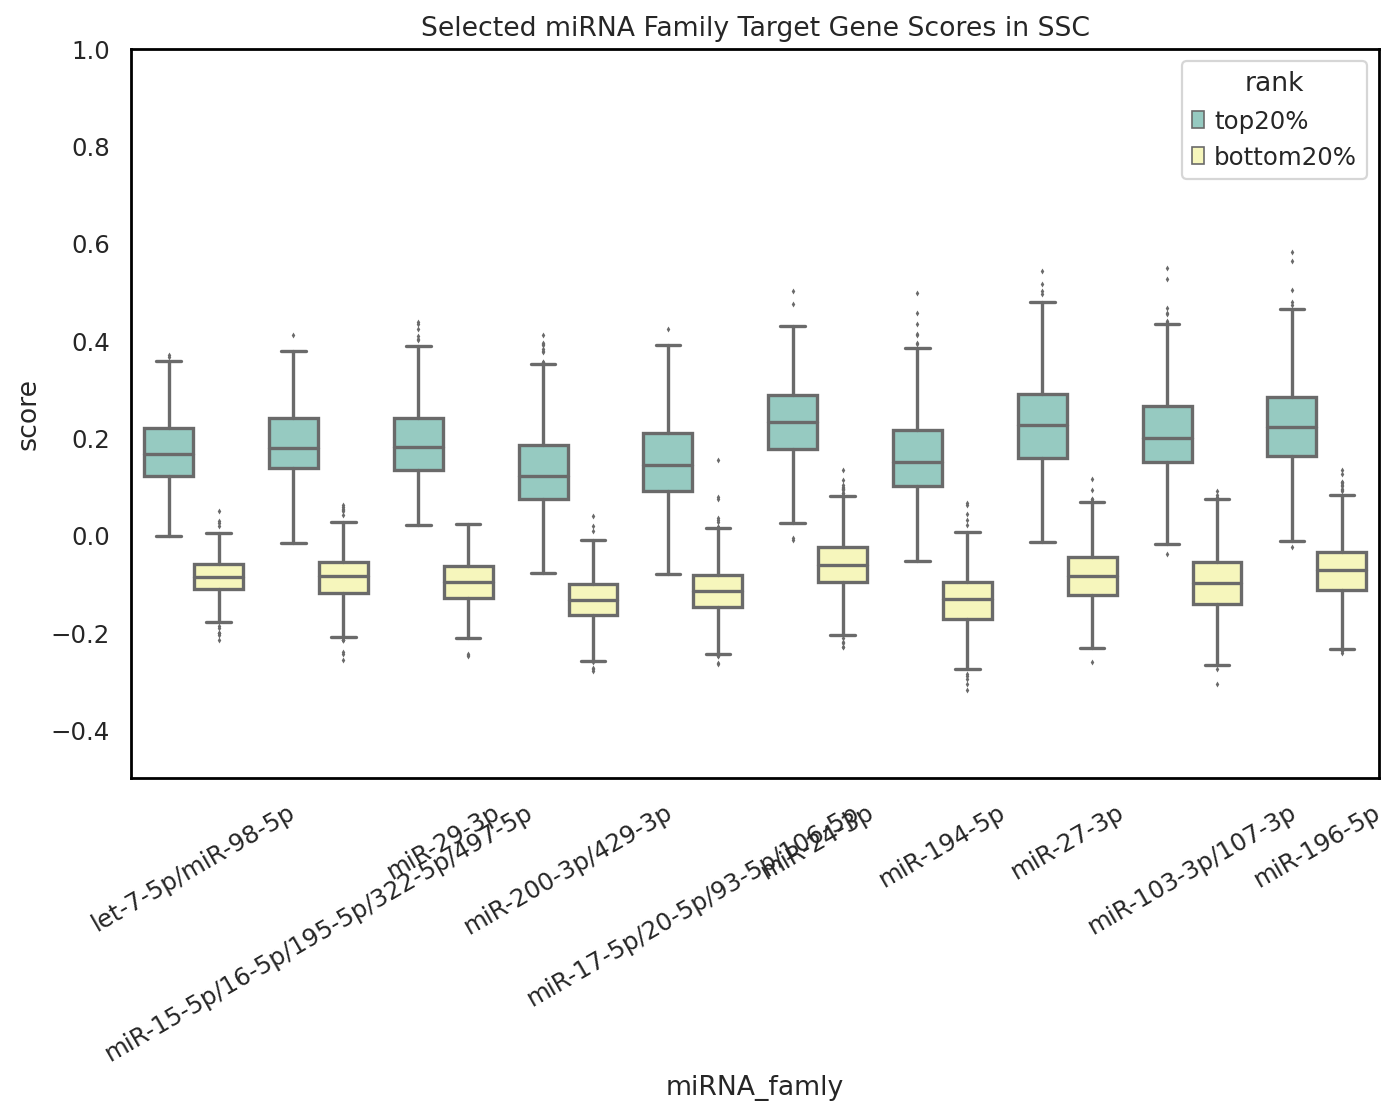

In [41]:
ssc_selected_fam_df = plot_score_df(ssc_rank_df2, selected_miR_fam, header, [0,10], 
                            "Selected miRNA Family Target Gene Scores in SSC",
                                   fig_size=(10,6), ylim=[-0.5,1],
                                   )
#save = "/home/lucy/CK_miRNA/figures/box_selected_fam_SSC.pdf"

In [42]:
# format with statistical tests
dat_df = long_format_score_df(ssc_rank_df2, selected_miR_fam, header, [0,10])

plotting_parameters = {
    "x": "miRNA_famly", 
    "y": "score", 
    "hue" : "rank", 
    "data" : dat_df, 
    "fliersize" : 0.5, 
    "palette": "Set3"
}



(14680, 3)


In [43]:
dat_df["miRNA_famly"][0]

'let-7-5p/miR-98-5p'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

miR-196-5p_top20% vs. miR-196-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:2.472e-239 U_stat=5.377e+05
miR-103-3p/107-3p_top20% vs. miR-103-3p/107-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:7.743e-240 U_stat=5.380e+05
miR-15-5p/16-5p/195-5p/322-5p/497-5p_top20% vs. miR-15-5p/16-5p/195-5p/322-5p/497-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:4.827e-241 U_stat=5.386e+05
let-7-5p/miR-98-5p_top20% vs. let-7-5p/miR-98-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:3.355e-241 U_stat=5.387e+05
miR-29-3p_top20% vs. miR-29-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:2.932e-241 U_stat=5.388e+05
miR-200-3p/429-3p_top20% vs. miR-200-3p/429-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:2.543e-240 U_stat=5.382e+05
miR-17-5p/20-5p/93-5p/106-5p_

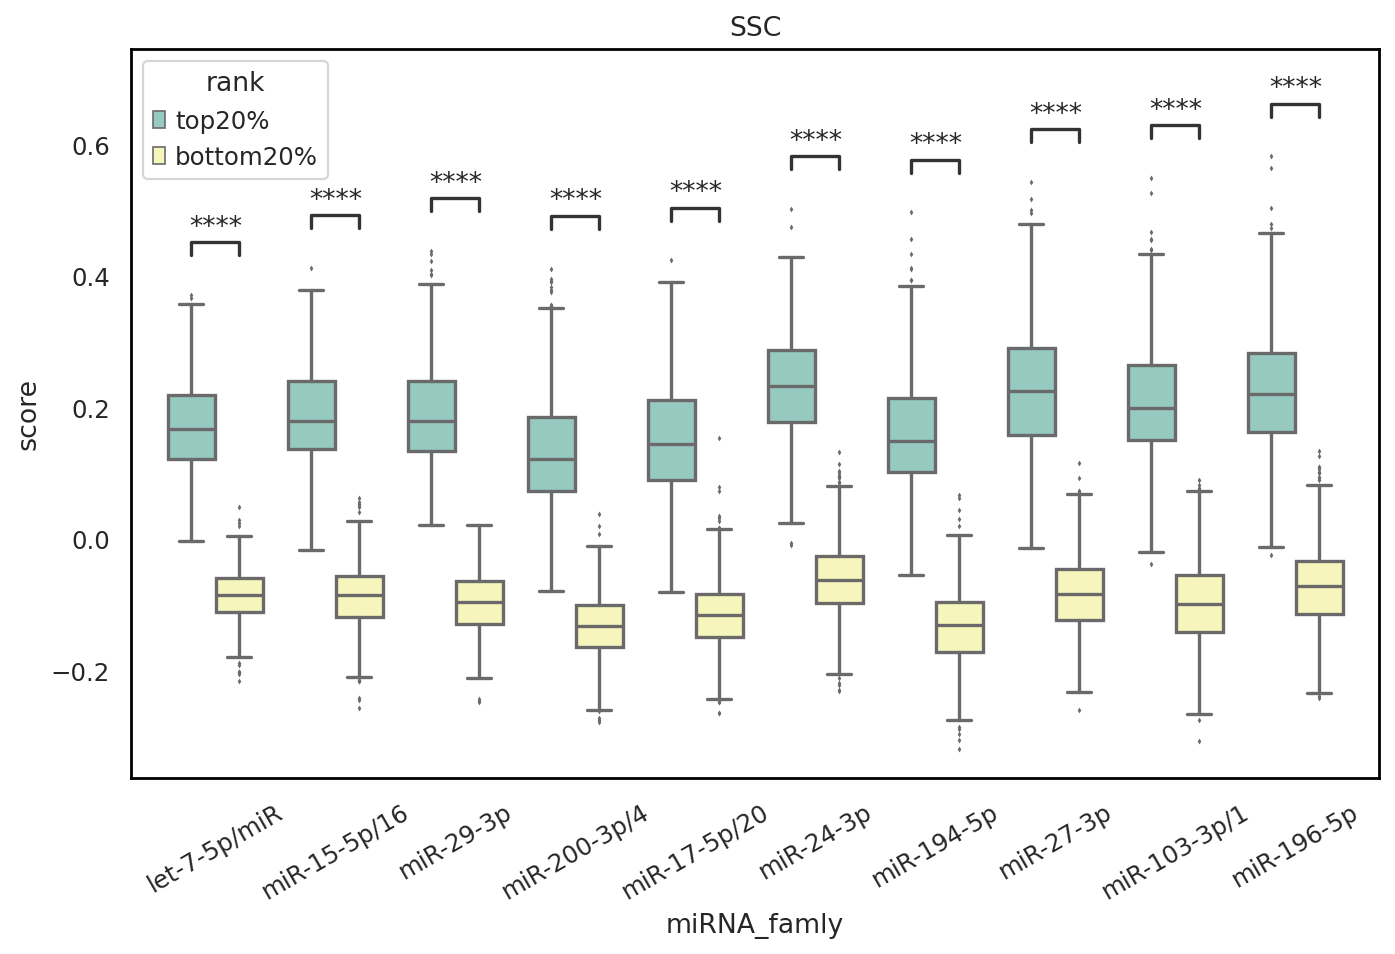

In [44]:
_,ax = plt.subplots()


plot_stat_annotation(plotting_parameters, dat_df, pairs, ax = ax)
short_selected_name = [fam[0:min(len(fam), 12)] for fam in selected_miR_fam]
ax.set_xticklabels(short_selected_name,rotation = 30)
ax.set_title("SSC")
ax.grid(False)
sn.set(rc = {'figure.figsize':(14,8), 'axes.edgecolor': 'black', 'axes.facecolor': 'white'})

#plt.savefig("./figures/box_SSC.pdf", bbox_inch = 'tight')

### GOB Analysis

In [96]:
gob = sc.read(os.path.join(data_path, "gob.h5ad"))
gob.X.sum(axis = 1)

array([ 4509.,  6191.,  3702., ...,  3424.,  2794., 11024.], dtype=float32)

In [98]:
gob_rank_df = pd.DataFrame(gob.obs["all_targets_gene_scores"])
gob_rank_df["rank"] = ["middle" for i in range(gob.n_obs)]

gob_rank_df = gob_rank_df.sort_values(by = "all_targets_gene_scores", ascending= False)
gob_rank_df["rank"][int(0.8*gob.n_obs):gob.n_obs] = "bottom20%" 
gob_rank_df["rank"][0:int(0.2*gob.n_obs ) ] = "top20%" 

gob_rank_df2 = pd.concat([gob_rank_df[gob_rank_df["rank"] == "top20%"],gob_rank_df[gob_rank_df["rank"] == "bottom20%"] ], axis = 0)
print(gob_rank_df2.shape)
gob_rank_df2

(4331, 2)


/tmp/ipykernel_128331/2005732681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gob_rank_df["rank"][int(0.8*gob.n_obs):gob.n_obs] = "bottom20%"
/home/lucy/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/tmp/ipykernel_128331/2005732681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gob_rank_df["rank"][0:int

,all_targets_gene_scores,rank
TACAGCCGAAACCTCC-90,0.282462,top20%
ACTGAGTGCCATCTCCC-4,0.257980,top20%
GATGCCATCGCTACGAGC-90,0.257950,top20%
AGAAGTGCCCATCTCCC-73,0.246645,top20%
GAGACAGATAGGTCACAG-90,0.245459,top20%
...,...,...
AATATCTTCCTCGATGC-0,-0.191447,bottom20%
TGAGCCACATCTTCGTTCC-20,-0.192299,bottom20%
AAATGAATGATGGAAAT-0,-0.196855,bottom20%
AGCTTTCCACTTTAATC-72,-0.199707,bottom20%


In [46]:
gob_selected_fam_df = plot_score_df(gob_rank_df2, selected_miR_fam, header, [0,10], 
                            "Selected miRNA Family Target Gene Scores in GOB",
                            fig_size=(10,6), ylim = [-1, 2],
                                  )
# save = "/home/lucy/CK_miRNA/figures/box_selected_fam_GOB.pdf"

In [67]:
rank_choice = ['top20%', 'bottom20%']

pairs = [ [(s, r)  for r in rank_choice] for s in selected_miR_fam ]

In [69]:
pairs[0:5]

[[('let-7-5p/miR-98-5p', 'top20%'), ('let-7-5p/miR-98-5p', 'bottom20%')],
 [('miR-15-5p/16-5p/195-5p/322-5p/497-5p', 'top20%'),
  ('miR-15-5p/16-5p/195-5p/322-5p/497-5p', 'bottom20%')],
 [('miR-29-3p', 'top20%'), ('miR-29-3p', 'bottom20%')],
 [('miR-200-3p/429-3p', 'top20%'), ('miR-200-3p/429-3p', 'bottom20%')],
 [('miR-17-5p/20-5p/93-5p/106-5p', 'top20%'),
  ('miR-17-5p/20-5p/93-5p/106-5p', 'bottom20%')]]

In [99]:
# format with statistical tests
dat_df = long_format_score_df(gob_rank_df2, selected_miR_fam, header, [0,10])

plotting_parameters = {
    "x": "miRNA_famly", 
    "y": "score", 
    "hue" : "rank", 
    "data" : dat_df, 
    "fliersize" : 0.5, 
    "palette": "Set3"
}



(43310, 3)


In [100]:
dat_df["miRNA_famly"][0]

'let-7-5p/miR-98-5p'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

miR-196-5p_top20% vs. miR-196-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.628e+06
miR-103-3p/107-3p_top20% vs. miR-103-3p/107-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.643e+06
miR-15-5p/16-5p/195-5p/322-5p/497-5p_top20% vs. miR-15-5p/16-5p/195-5p/322-5p/497-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.677e+06
let-7-5p/miR-98-5p_top20% vs. let-7-5p/miR-98-5p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.689e+06
miR-29-3p_top20% vs. miR-29-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.685e+06
miR-200-3p/429-3p_top20% vs. miR-200-3p/429-3p_bottom20%: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.680e+06
miR-17-5p/20-5p/93-5p/106-5p_top20%

/tmp/ipykernel_128331/1530295435.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("./figures/box_GOB.pdf", bbox_inch = 'tight')


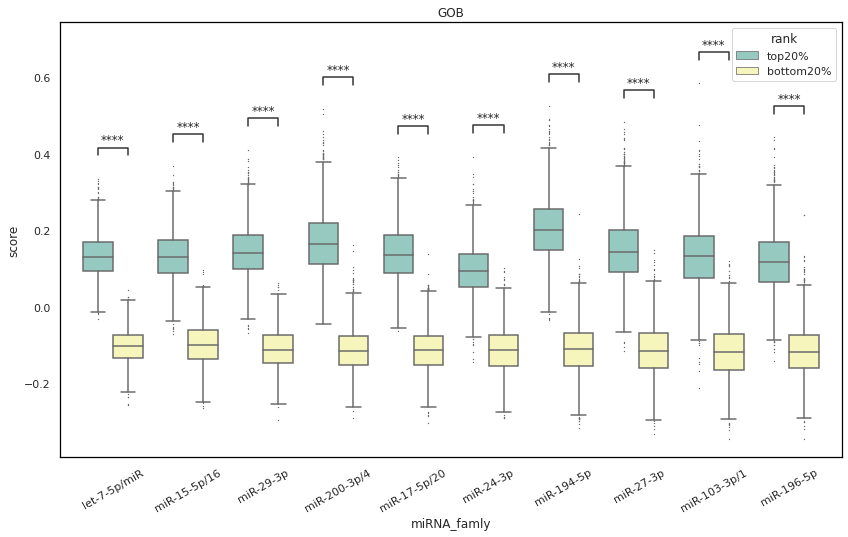

In [102]:
_,ax = plt.subplots()


plot_stat_annotation(plotting_parameters, dat_df, pairs, ax = ax)
short_selected_name = [fam[0:min(len(fam), 12)] for fam in selected_miR_fam]
ax.set_xticklabels(short_selected_name,rotation = 30)
ax.set_title("GOB")
ax.grid(False)
sn.set(rc = {'figure.figsize':(14,8), 'axes.edgecolor': 'black', 'axes.facecolor': 'white'})
plt.savefig("./figures/box_GOB.pdf", bbox_inch = 'tight')